In [37]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
#from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [38]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "02346908" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "am7522" # Return your short imperial login

## Helper class

In [39]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """

    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """

    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """

    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """

    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """

    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """

    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [40]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """ Maze initialisation.

    input: /
    output: /

    """
    
    # Properties set from the CID (y=0), (z=8)

    self._prob_success = 0.8 + 0.02 * (9-0) # float
    self._gamma = 0.8 + (0.02 * 0) # float
    self._goal = 0 # (0 for R0, 1 for R1, 2 for R2, 3 for R3)  [8%8 = 0 (R0)]

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """ Maze initialisation.

    input: /
    output: /

    """

    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # MAZE INITIALISATION

    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles

    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ] # Reward of absorbing states
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] # Location of start states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # ACTIONS

    
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # STATES
    # self._locations 


    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc): 
          # _is_location checks the state is within grid range, and not obstacle state
          self._locations.append(loc)

    self._state_size = len(self._locations)

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # NEIGHBOURS
    # self._neighbours 


    # Neighbours - each row is a state index, each column is a direction (N, E, S, W)
    # Neighbouring states of all possible states
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # NORTH.
      neighbour = (loc[0]-1, loc[1]) 
      if self._is_location(neighbour): # North neighbour location
        # Assign to neighbours matrix.
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour) 

      else: 
         # If there is no valid neighbour to North, return to itself.
        self._neighbours[state][self._direction_names.index('N')] = state 

      # EAST
      neighbour = (loc[0], loc[1]+1) # East neighbour location
      if self._is_location(neighbour):
        # Assign to neuighbours matrix.
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)

      else: 
        # If there is no valid neighbour to East, return to itself.
        self._neighbours[state][self._direction_names.index('E')] = state

      # SOUTH
      neighbour = (loc[0]+1, loc[1]) # South neighbour location
      if self._is_location(neighbour):
        # Assign to neighbours matrix.
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)

      else: 
         # If there is no valid neighbour to South, return to itself.
        self._neighbours[state][self._direction_names.index('S')] = state

      # WEST
      neighbour = (loc[0], loc[1]-1) # West neighbour location
      if self._is_location(neighbour):
        # Assign to neighbours matrix.
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)

      else: 
        # If there is no valid neighbour to West, return to itself.
        self._neighbours[state][self._direction_names.index('W')] = state
    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # ABSORBING 
    # self._absorbing

    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1
    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------


    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # TRANSITION_MATRIX 
    # self._T


    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # REWARD
    # self._R

    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------


  def _is_location(self, loc):
    """ Is the location a valid state (not out of Maze and not an obstacle)

    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state

    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """ Get the state number corresponding to a given location

    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number

    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """ Get the location tuple corresponding to a given state number

    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents --------------------------------------------------------------

  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing
  
  # ---------------------------------------------------------------------------------------------------------

  # Getter functions used for DP, MC and TD agents ----------------------------------------------------------

  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma
  
   # ---------------------------------------------------------------------------------------------------------

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: 

    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """ Perform an action in the environment

    input: action {int} -- action to perform

    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done
    

## Dynamic Programming (DP) Agent

In [41]:
# This class define the Dynamic Programing agent 

class DP_agent(object):

  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """ Solve a given Maze environment using Dynamic Programming

    input: env {Maze object} -- Maze to solve

    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function

    """
    
    # INITIALISATION --------------------------------------------------------------------------------------------
    
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    threshold = 0.0001

    # ------------------------------------------------------------------------------------------------------------

    # policy, V, epochs = policy_iteration(env, threshold, gamma)
    policy, V, epochs = value_iteration(env, threshold, gamma)


    return policy, V
  

def policy_evaluation(env, policy, threshold, gamma):
    """ Policy evaluation

    input: 
      - policy (np.array) -- policy to evaluate, shape (SxA) where S = #states, A = #actions
      - threshold (float) -- threshold value used to stop the policy evaluation algorithm
      - gamma (float) -- discount factor

    output: 
      - V (np.array) -- value function corresponding to the policy, shape (S,), where S = #states
      - epoch (int) -- number of epochs to find this value function

    """
    
    # Ensure valid input shapes
    assert (policy.shape[0] == env.get_state_size()) and (policy.shape[1] == env.get_action_size()), "The dimensions of the policy are not valid."
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    delta= 2*threshold # delta > threshold to start the loop
    V = np.zeros(env.get_state_size()) # Initialise value function to all 0s
    Vnew = np.copy(V) # Deep copy of the value array to hold the update during the evaluation    
    epoch = 0

    # Loop until convergence
    while delta > threshold:
      epoch += 1

      for prior_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prior_state]: # Ensure state is non-absorbing

          tmpV = 0 # Temporary variable for V
          for action in range(env.get_action_size()):
            tmpQ = 0 # Temporary variable for Q
            for next_state in range(env.get_state_size()):
              # only 4 cases (if no obstacles) will add value because only 4 neighbours
              tmpQ = tmpQ + env.get_T()[prior_state, next_state, action] * ( env.get_R()[prior_state, next_state, action] + gamma * V[next_state])
            
            tmpV += policy[prior_state, action] * tmpQ
                    
          # Update the value of the state
          Vnew[prior_state] = tmpV
            
      # Compute new delta (other stopping criteria may be used)
      delta =  max(abs(Vnew - V))

      # Update V
      V = np.copy(Vnew)
            
    return V, epoch


    
def policy_iteration(env, threshold, gamma):
    """ Policy iteration

    input: 
      - threshold {float} -- threshold value used to stop the policy iteration algorithm
      - gamma {float} -- discount factor

    output:
      - policy {np.array} -- policy found using the policy iteration algorithm
      - V {np.array} -- value function corresponding to the policy 
      - epochs {int} -- number of epochs to find this policy

    """

    # Ensure gamma value is valid
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    policy[:, 0] = 1 # Initialise policy to choose action 1 systematically
    epochs = 0
    policy_stable = False # Condition to stop the main loop

    while not policy_stable: 

      # Policy evaluation
      V, epochs_eval = policy_evaluation(env, policy, threshold, gamma)
      epochs += epochs_eval # Increment epoch

      # Set the boolean to True, it will be set to False later if the policy prove unstable
      policy_stable = True

      # Policy iteration
      for prior_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prior_state]: # Ensure state are non-absorbing
                    
          # Store the old action (used for convergence criterion)
          old_action = np.argmax(policy[prior_state, :])
                
          # Compute Q value
          Q = np.zeros(env.get_action_size()) # Initialise with value 0
          for next_state in range(env.get_state_size()):
            Q += env.get_T()[prior_state, next_state, :] * (env.get_R()[prior_state, next_state, :] + gamma * V[next_state])

          # Compute optimal policy for prior state
          new_policy = np.zeros(env.get_action_size())
          new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
          
          # Add to general policy
          policy[prior_state, :] = new_policy
                
          # Check if the policy has converged
          if old_action != np.argmax(policy[prior_state, :]):
            policy_stable = False
            
    return policy, V, epochs

def value_iteration(env, threshold, gamma):
    """ Value iteration.

    input: 
      - threshold (float) -- threshold value used to stop the value iteration algorithm
      - gamma (float) -- discount factor

    output: 
      - policy (np.array) -- optimal policy found using the value iteration algorithm
      - V (np.array) -- value function corresponding to the policy
      - epochs (int) -- number of epochs to find this policy
      
    """

    # Ensure gamma value is valid
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    epochs = 0
    delta = threshold # Setting value of delta to go through the first breaking condition
    V = np.zeros(env.get_state_size()) # Initialise values at 0 for each state

    while delta >= threshold:
      epochs += 1 # Increment the epoch
      delta = 0 # Reinitialise delta value

      # For each state
      for prior_state in range(env.get_state_size()):

        # If not an absorbing state
         if not env.get_absorbing()[0, prior_state]: # Ensure state are non-absorbing
                  
          # Store the previous value for that state
          v = V[prior_state] 

          # Compute Q value
          # Q = np.zeros(4) # Initialise with value 0
          Q = 0

          for post_state in range(env.get_state_size()):
              Q += env.get_T()[prior_state, post_state,:] * (env.get_R()[prior_state, post_state, :] + gamma * V[post_state])
  
          # Set the new value to the maximum of Q
          V[prior_state]= np.max(Q) 

          # Compute the new delta
          delta = max(delta, np.abs(v - V[prior_state]))
            
            
    # When the loop is finished, fill in the optimal policy
    policy = np.zeros((env.get_state_size(), env.get_action_size())) # Initialisation

    for prior_state in range(env.get_state_size()):
      # Compute the Q value
      Q = np.zeros(4)
      for post_state in range(env.get_state_size()):
        Q += env.get_T()[prior_state, post_state, : ] * (env.get_R()[prior_state, post_state, :] + gamma * V[post_state])
            
      # The action that maximises the Q value gets probability 1
      policy[prior_state, np.argmax(Q)] = 1 

    return policy, V, epochs
    

Creating the Maze:



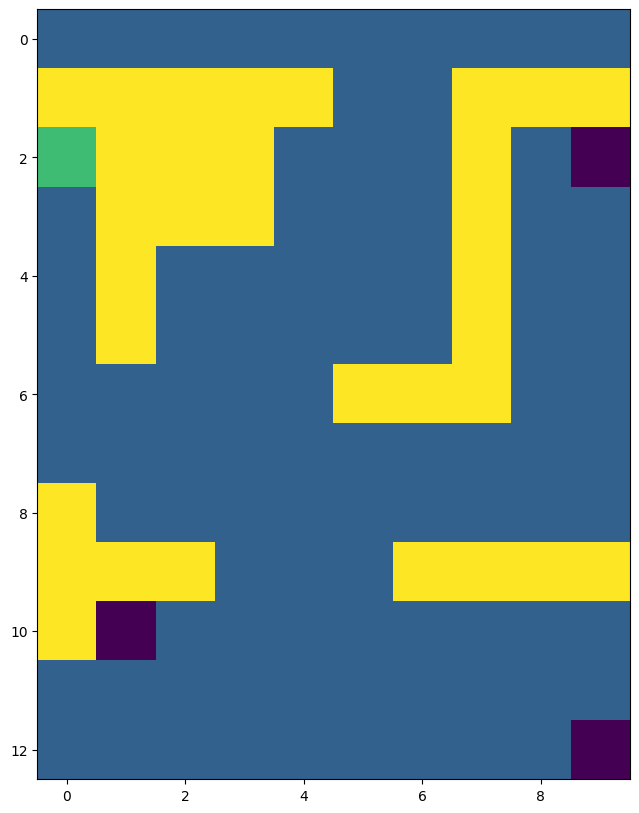

Results of the DP agent:



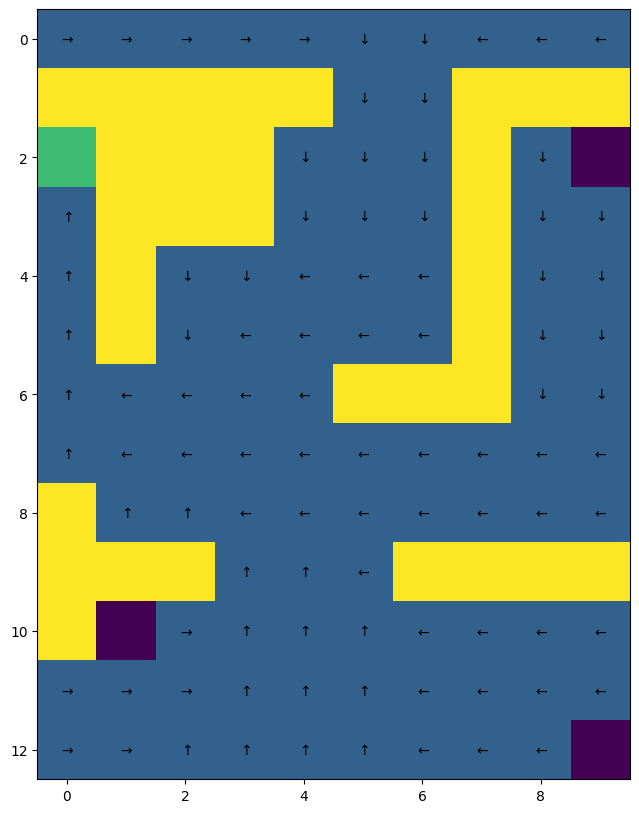

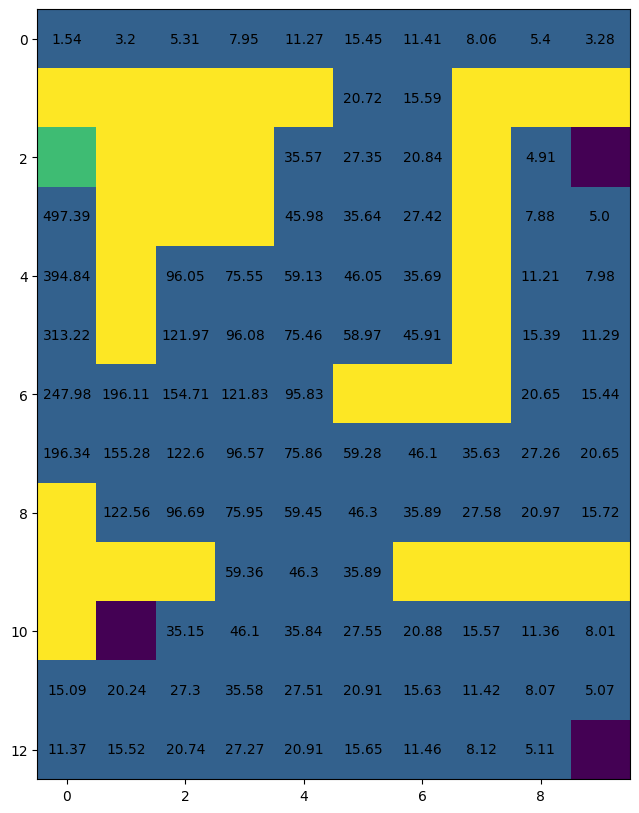

In [42]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming (Policy Eval + Policy Iter)

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


## MC agent

In [117]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """ Solve a given Maze environment using Monte Carlo learning

    input: env {Maze object} -- Maze to solve

    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 

    """

    # INITIALISATION --------------------------------------------------------------------------------------------------------
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())

    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    epsilon_greedy_p = 0.25

    for state in range(env.get_state_size()):
      greedy_action = np.argmax(Q[state])
      for action in range(env.get_action_size()):
        if action == greedy_action:
          policy[state, action] = 1 - epsilon_greedy_p + (epsilon_greedy_p / env.get_action_size())
        else:
          policy[state, action] = epsilon_greedy_p / env.get_action_size()
        V[state] += policy[state,action] + Q[state,action]
  
    # print(policy[0:5])
    values = [np.copy(V)]
    total_rewards = []
    n = 10000
    learning_rate = 0.005


    # -------------------------------------------------------------------------------------------------------------------------
    counter = 0

    while counter < n:
      print(counter)

      # 1. Get Trace using policy
      step, state, reward, done = env.reset()
      episode = []

      while done == False:
        # get action using policy
        action = np.random.choice([0,1,2,3], p = policy[state], size=1)
        episode.append((state, action, reward, step))
        step, state, reward, done = env.step(action)
      
      episode.append((state, action, reward, step)) # final step (with absorbing reward)
      
     
      if episode[-1][2] == -1:
        continue
        
      # 2. First visit online MC
      visited = []
      rewards = 0
      R = 0

      for index, (state, action, reward, step) in enumerate(episode):


        if (state, action) in visited:
          continue # first_visit

        else:
          # incremental update (online)
          R = 0 
          R += reward
         

          for index_i, (_, _, reward_i, step_i) in enumerate(episode):
            if step_i > step:
              R += np.power(env.get_gamma(), (step_i-step)-1) * reward_i
          
          # print("step {} R: {}".format(step, R))
          Q[state, action] = Q[state, action] + learning_rate*(R - Q[state, action])
          rewards += reward
          visited.append((state,action))
      
     
      visited.append(V)
      total_rewards.append(rewards)
      
      visited_states = []

       # 3. Improve Policy and update value function.
      for index, (state, action, reward, step) in enumerate(episode):
        if (state,action) in visited_states:
          continue

        V[state] = 0
        state_rewards = Q[state,:].squeeze() 
        greedy_action = np.argmax(state_rewards)
        # print("state: {}".format(state))
        # print("state_rewards: {}".format(state_rewards))
        # print("greedy action: {}".format(greedy_action))
        # print(greedy_action)

        for action in range(env.get_action_size()):
          V[state] += policy[state, action] * Q[state, action]

        for action in range(env.get_action_size()):
          if action == greedy_action:
            policy[state, action] = 1 - epsilon_greedy_p + (epsilon_greedy_p / env.get_action_size() )
          else:
            policy[state, action] = epsilon_greedy_p / env.get_action_size()

        # print("new policy: ")
        # print( policy[state, :])
        # print("")
        values.append(np.copy(V))
        visited_states.append((state,action))
        
      counter += 1


    for state in range(env.get_state_size()): 
      best_action = np.argmax(Q[state,:])
      policy[state, : ] = 0
      policy[state, best_action ] = 1 

    return policy, values, total_rewards

Creating the Maze:



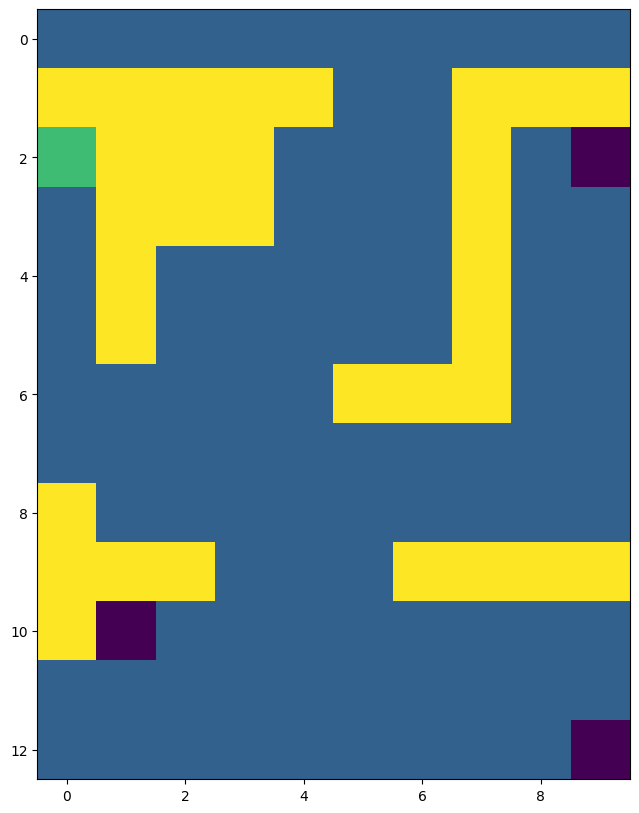

0
1
2
2
2
2
2
3
3
4
4
4
4
4
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
21
21
21
21
22
22
22
23
23
24
24
24
24
24
24
24
25
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
27
27
27
28
28
28
28
29
29
29
29
30
31
31
31
31
31
31
31
31
31
31
31
32
33
33
33
34

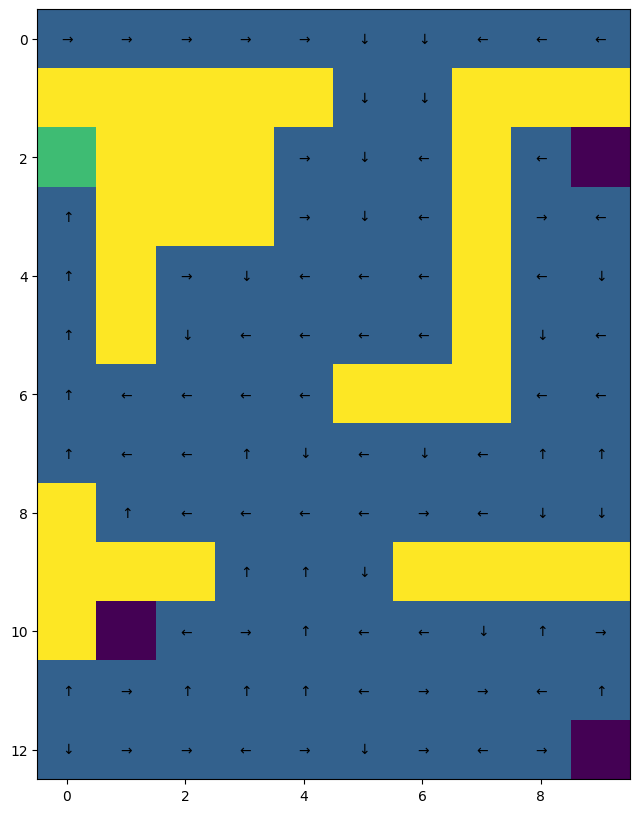

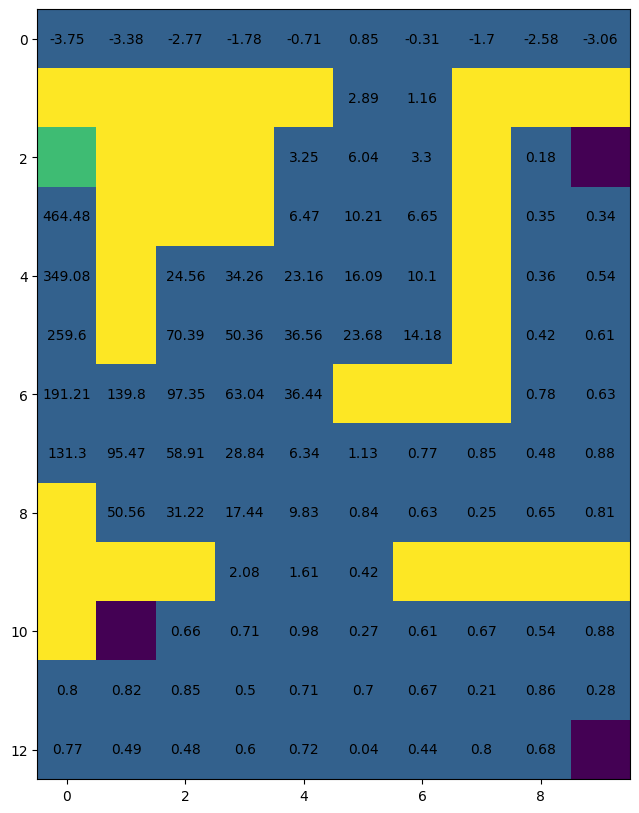

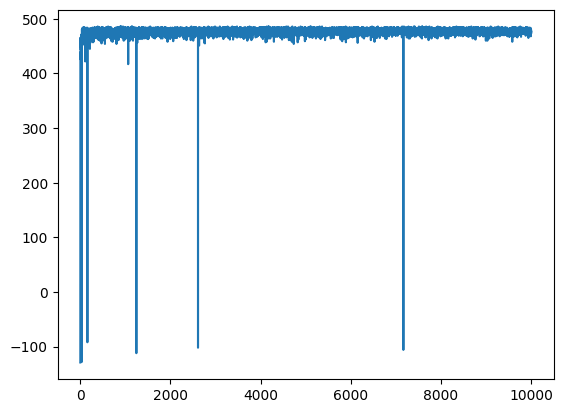

In [118]:
### Question 2: Monte-Carlo learning

print("Creating the Maze:\n")
maze = Maze()
mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)
print("Results of the MC agent:\n")


maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])
plt.plot(total_rewards)

## TD agent

In [69]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # INITIALISATION ----------------------------------------------------------------

    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    Q = np.zeros((env.get_state_size(), env.get_action_size()))
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size()))

    # ------------------------------------------------------------------------------

    counter = 0
    epsilon = 0
    learning_rate = 0.1
    n = 5000

    for state in range(env.get_state_size()):
      greedy_action = np.argmax(Q[state,:])

      for action in range(env.get_action_size()):
        if action == greedy_action:
          policy[state, action] = 1 - epsilon + epsilon / env.get_action_size()
        else:
          policy[state, action] = epsilon / env.get_action_size()

        V[state] += policy[state, action] * Q[state, action]

    values = [np.copy(V)]
    total_rewards = []
    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####

    while counter < n:
      step, state, reward, done = env.reset()
      total_reward = reward
      visited = set()

      while not done:
        visited.add(state)
        probs = np.full(env.get_action_size(), epsilon / env.get_action_size())
        probs[np.argmax(Q[state])] += 1 - epsilon

        action = np.random.choice(env.get_action_size(), size=None, p=probs)
        step, next_state, reward, done = env.step(action)

        Q[state, action] = Q[state, action] + learning_rate * (reward + env.get_gamma() * np.max(Q[next_state]) - Q[state, action])

        state = next_state
        total_reward += reward
 
      visited.add(state)
      counter += 1
      total_rewards.append(total_reward)
      for s in visited:
        V[s] = np.max(Q[s])
        
      values.append(np.copy(V))
      
    
    for state in range(env.get_state_size()):
      policy[state,:] = 0
      policy[state, np.argmax(Q[state])] = 1

    
    return policy, values, total_rewards

Results of the TD agent:



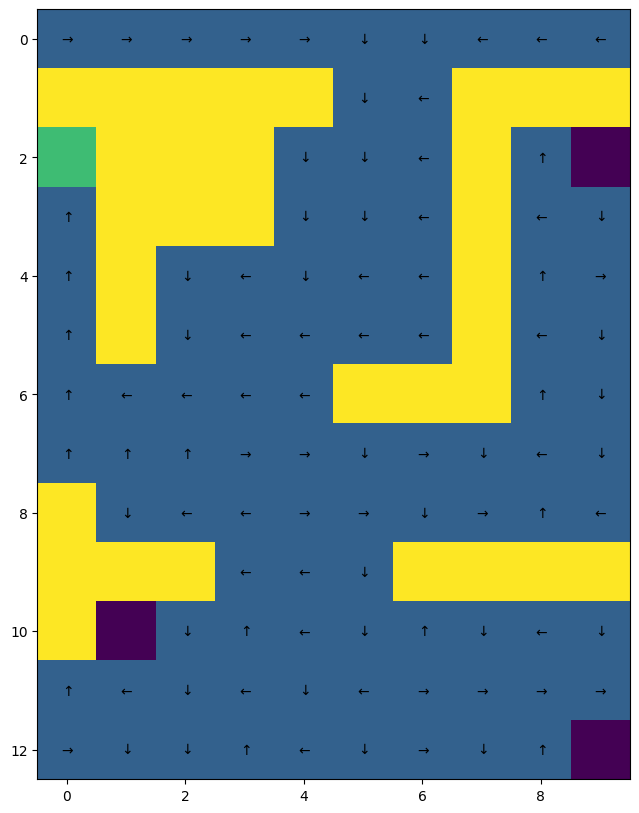

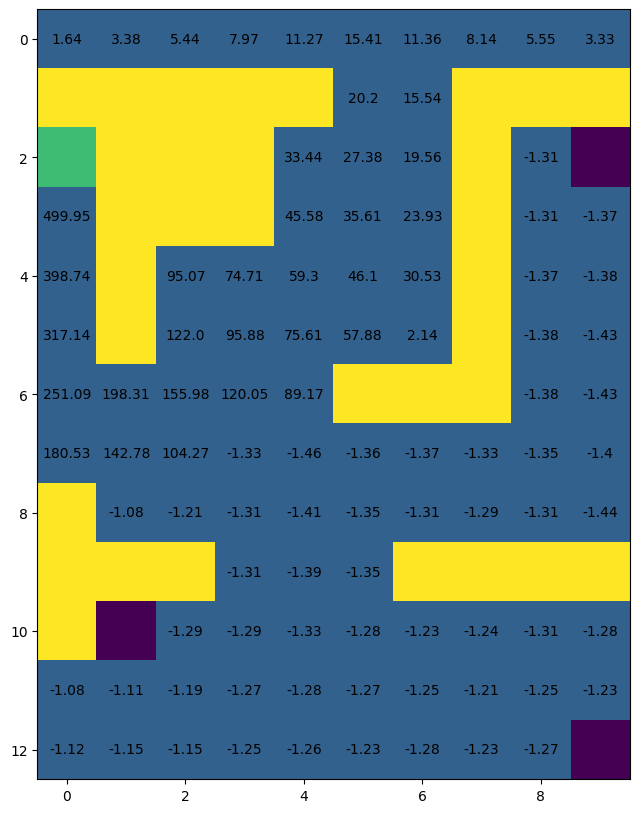

In [70]:
### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

## Example main

Creating the Maze:



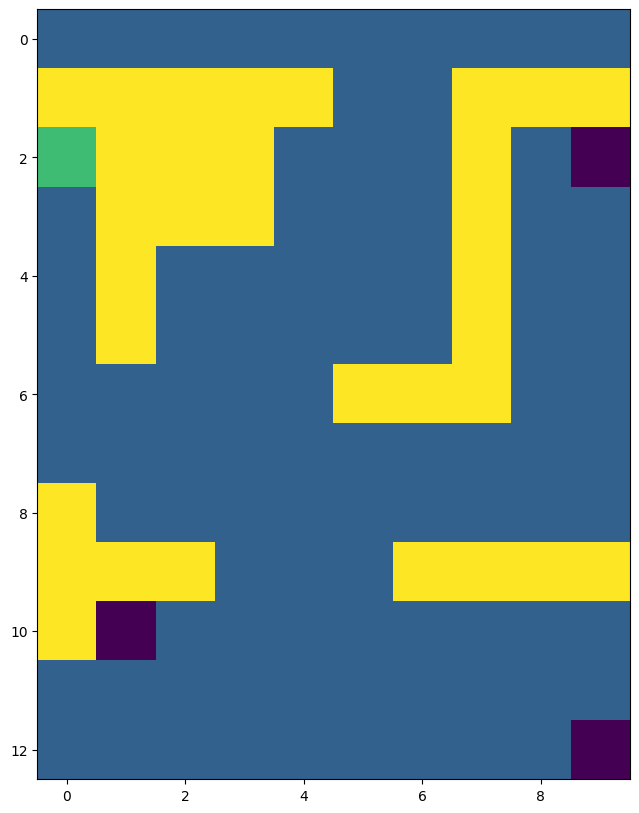

Results of the DP agent:



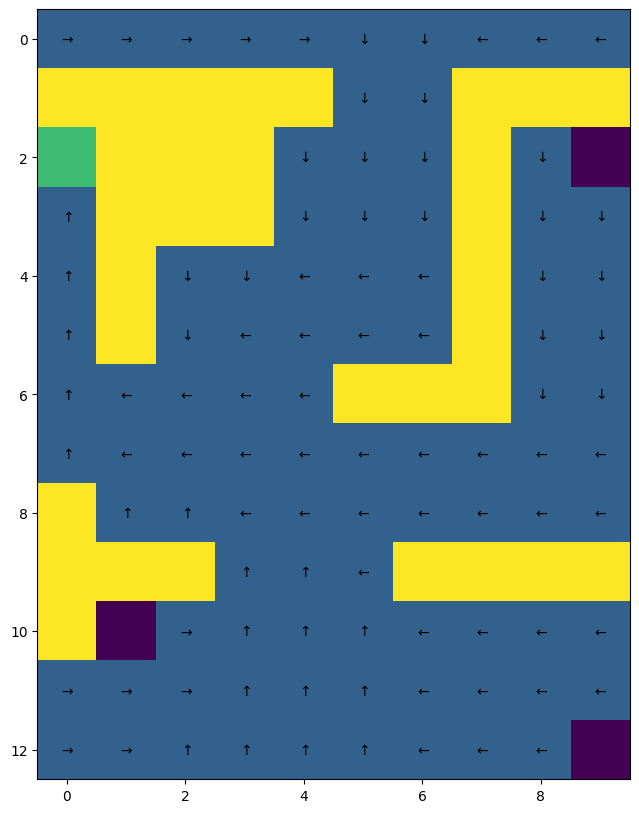

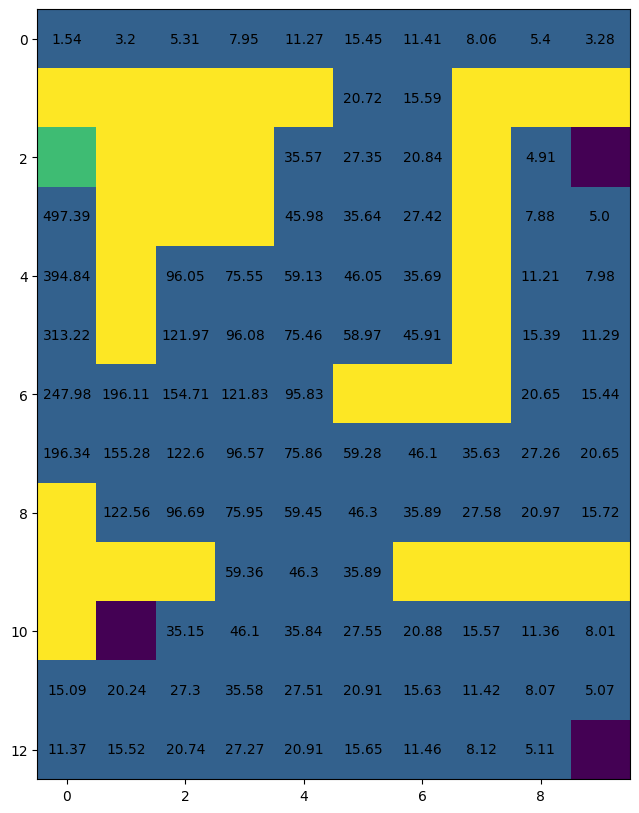

NameError: name 'MC_agent' is not defined

In [7]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)

